In [221]:
import pandas as pd
import numpy as np

# For Content-Based Filtering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# For Collaborative Filtering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Load the orders dataset from the local 'dataset' folder
orders_df = pd.read_csv('dataset/olist_orders_dataset.csv')
customers_df = pd.read_csv('dataset/olist_customers_dataset.csv')
geolocation_df = pd.read_csv('dataset/olist_geolocation_dataset.csv')
order_items_df = pd.read_csv('dataset/olist_order_items_dataset.csv')
order_payments_df = pd.read_csv('dataset/olist_order_payments_dataset.csv')
order_reviews_df = pd.read_csv('dataset/olist_order_reviews_dataset.csv')
products_df = pd.read_csv('dataset/olist_products_dataset.csv')
sellers_df = pd.read_csv('dataset/olist_sellers_dataset.csv')
product_category_name_translation_df = pd.read_csv('dataset/product_category_name_translation.csv')

In [222]:
orders_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [223]:
#customers_df.head()

In [224]:
#geolocation_df.head()

In [225]:
#order_items_df.head()

In [226]:
#order_payments_df.head()

In [227]:
#order_reviews_df.head()

In [228]:
#products_df.head()

In [229]:
#sellers_df.head()

In [230]:
#product_category_name_translation_df.head()

In [231]:
# 1. Merge orders with customers to get customer_unique_id
merged_df = orders_df.merge(customers_df, on='customer_id')

# 2. Merge with order_items to get product_id
merged_df = merged_df.merge(order_items_df, on='order_id')

# 3. Merge with order_reviews to get review_score
merged_df = merged_df.merge(order_reviews_df, on='order_id')

# 4. Merge with products to get product name
merged_df = merged_df.merge(products_df, on='product_id')

# 5. Create the final "ratings" dataframe with review count
ratings_df = merged_df.groupby(['product_id'])['review_score'] \
    .agg(['mean', 'count']).reset_index() \
    .rename(columns={'mean': 'reviews_average', 'count': 'reviews_count'})

print(f"Created ratings_df with {ratings_df.shape[0]} unique ratings.")
ratings_df.head()


Created ratings_df with 32789 unique ratings.


,product_id,reviews_average,reviews_count
0,00066f42aeeb9f3007548bb9d3f33c38,5.0,1
1,00088930e925c41fd95ebfe695fd2655,4.0,1
2,0009406fd7479715e4bef61dd91f2462,1.0,1
3,000b8f95fcb9e0096488278317764d19,5.0,2
4,000d9be29b5207b54e86aa1b1ac54872,5.0,1


In [232]:
merged_df['product_category_name'].head()

0    utilidades_domesticas
1               perfumaria
2               automotivo
3                 pet_shop
4                papelaria
Name: product_category_name, dtype: object

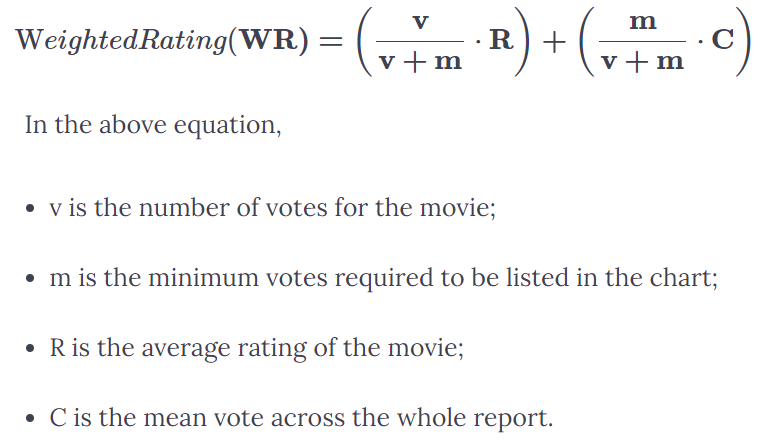

In [233]:
from IPython.display import Image
Image(filename =r'Im1.png')

In [234]:
# Calculate mean of vote average column
C = ratings_df['reviews_average'].mean()
print(C)

4.047806761501803


In [235]:
# Calculate the minimum number of votes required to be in the chart, m
m = ratings_df['reviews_count'].sum()
print(m)

112372


In [236]:
# Calculate the total votes 
m = ratings_df['reviews_count'].quantile(0.90)
print(m)

6.0


In [237]:
# Filter out all qualified movies into a new DataFrame
q_ratings = ratings_df.copy().loc[ratings_df['reviews_count'] >= m]
q_ratings.shape

(3843, 3)

In [238]:
ratings_df.shape

(32789, 3)

In [239]:
# Function that computes the weighted rating of each movie
def weighted_rating(x, m = m, C = C):
    v = x['reviews_count']
    R = x['reviews_average']
    # Calculation based on the IMDB formula
    return (v / (v + m) * R) + (m / (m + v) * C)

In [240]:
# Define a new feature 'score' and calculate its value with `weighted_rating()`
q_ratings['score'] = q_ratings.apply(weighted_rating, axis = 1)

In [241]:
# Sort movies based on score calculated above
q_ratings = q_ratings.sort_values('score', ascending = False)

# Print top 20 movies
q_ratings[['product_id', 'reviews_count', 'reviews_average', 'score']].head(20)

,product_id,reviews_count,reviews_average,score
8054,3e4176d545618ed02f382a3057de32b4,24,4.958333,4.776228
14854,73326828aa5efe1ba096223de496f596,54,4.833333,4.754781
7224,37eb69aca8718e843d897aa7b82f462d,15,5.000000,4.727945
31754,f7f59e6186e10983a061ac7bdb3494d6,39,4.820513,4.717485
17316,870bcc6c58e03ca658cfdd13db4bbe28,14,5.000000,4.714342
16631,8173ca41cdb176462f9ae79821a48404,14,5.000000,4.714342
17835,8b6ed41158b194711f83b8da92757544,14,5.000000,4.714342
466,03e1c946c0ddfc58724ff262aef08dff,14,5.000000,4.714342
29699,e7f85e7f0203b7b95cc1b4c21b4b070c,23,4.869565,4.699546
5151,2722b7e5f68e776d18fe901638034e54,13,5.000000,4.699307


## Content-Based Recommender